In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.colors as clrs
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest, f_classif

fp_ds1 = "./heart_failure_clinical_records_dataset.csv"
original = pd.read_csv(fp_ds1, parse_dates=False, sep=',')

In [17]:
import datetime as dt

NR_COLUMNS: int = 3
HEIGHT: int = 4


def choose_grid(nr):
    if nr < NR_COLUMNS:
        return 1, nr
    else:
        return (nr // NR_COLUMNS, NR_COLUMNS) if nr % NR_COLUMNS == 0 else (nr // NR_COLUMNS + 1, NR_COLUMNS)


def set_axes(xvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '', ylabel: str = '', percentage=False):
    if ax is None:
        ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(xvalues, fontsize='small', ha='center')

    return ax


def set_locators(xvalues: list, ax: plt.Axes = None):
    if isinstance(xvalues[0], dt.datetime):
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator, defaultfmt='%Y-%m-%d'))
    else:
        ax.set_xticks(xvalues)
        ax.set_xlim(xvalues[0], xvalues[-1])

    return ax


def plot_line(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '',
              ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)
    ax.plot(xvalues,  yvalues, c=cfg.LINE_COLOR)


def multiple_line_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                        xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)

    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend)


def bar_chart(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '',
              xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax.bar(xvalues, yvalues, edgecolor=my_palette['dark blue'], color=my_palette['pale blue'])


def multiple_bar_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                       xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)

    x = np.arange(len(xvalues))  # the label locations

    width = 0.8 / (len(xvalues)*len(yvalues))
    # the width of the bars
    step = width / len(xvalues)
    i: int = 0
    for metric in yvalues:
        ax.bar(x + i*width, yvalues[metric], width=width, align='center', label=metric)
        i += 1
    ax.set_xticks(x + width/len(xvalues) - step/2)
    ax.legend(fontsize='x-small', title_fontsize='small')


def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray,
                          ax: plt.Axes = None, normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=clrs.LinearSegmentedColormap.from_list("myCMPBlues", [my_palette['pale blue'], my_palette['blue2'], my_palette['blue3'], my_palette['dark blue']]))

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='w', horizontalalignment="center")


def plot_evaluation_results(labels: np.ndarray, trn_y, prd_trn, tst_y, prd_tst):
    cnf_mtx_trn = metrics.confusion_matrix(trn_y, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tst_y, prd_tst, labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

    evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                               (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                  'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                  'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                  'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

    fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])


def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")

In [18]:
original.describe(include='all')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [19]:
sb_vars = original.select_dtypes(include='object')
original[sb_vars.columns] = original.select_dtypes(['object']).apply(lambda x: x.astype('category'))

cols_nr = original.select_dtypes(include='number')
cols_sb = original.select_dtypes(include='category')
original.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [20]:
#No Values Missing
cols_nr

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


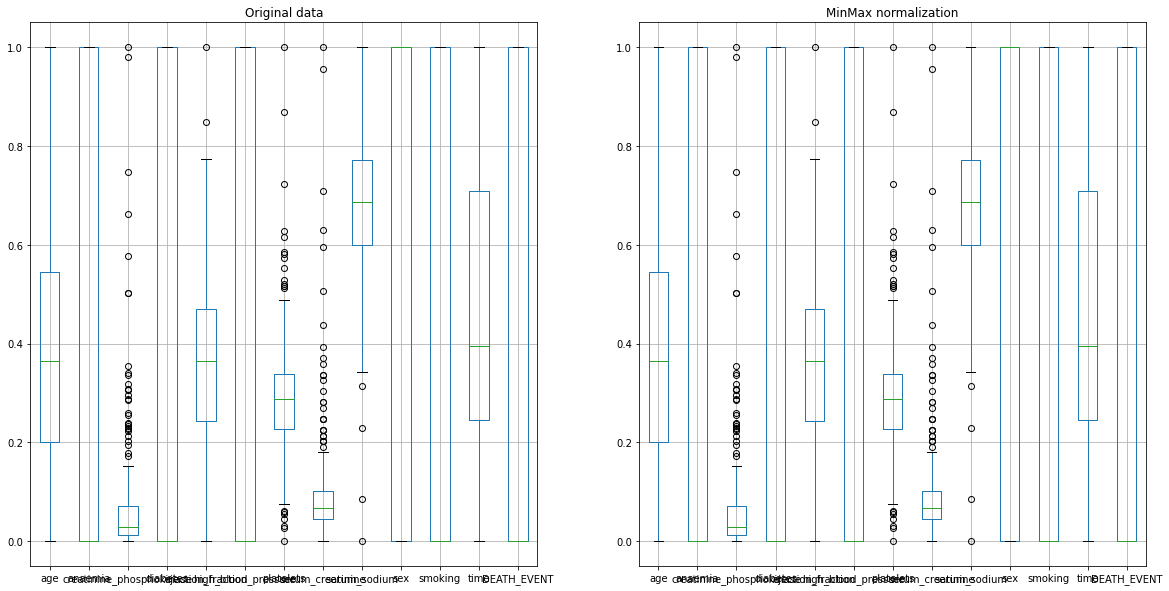

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(cols_nr)
cols_nr = pd.DataFrame(transf.transform(cols_nr), columns= cols_nr.columns)
norm_data_minmax = cols_nr.join(cols_sb, how='right')
norm_data_minmax.describe(include='all')

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
cols_nr.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 1])
#fig.tight_layout()
plt.show()

In [28]:
norm_data_minmax.describe(include='all')
print(norm_data_minmax.shape)

(224, 13)


In [29]:
norm_data_minmax.to_csv(r'DS1_not_balanced_just_scaled.csv')

In [30]:
for col in norm_data_minmax:
    if(col != 'DEATH_EVENT'):
        Q1=norm_data_minmax[col].quantile(0.25)
        Q3=norm_data_minmax[col].quantile(0.75)
        iqr=Q3-Q1
        lowerlimit=Q1-1.5*iqr
        upperlimit=Q3+1.5*iqr
        norm_data_minmax=norm_data_minmax[(norm_data_minmax[col]>lowerlimit) & (norm_data_minmax[col]<upperlimit)]

In [31]:
norm_data_minmax.shape

(213, 13)

In [32]:
norm_data_minmax.to_csv(r'DS1_scaled_and_no_outliers.csv')

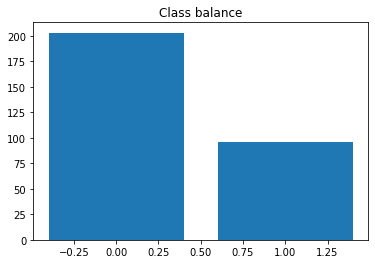

Minority class: 96
Majority class: 203
Proportion: 0.47 : 1


In [9]:
import matplotlib.pyplot as plt

target_count = norm_data_minmax['DEATH_EVENT'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')

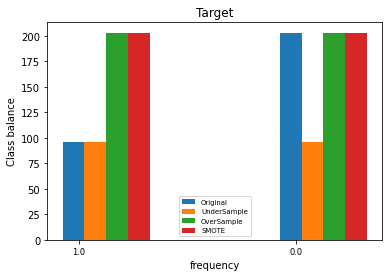

In [10]:
#import ds_functions as ds
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = norm_data_minmax[norm_data_minmax['DEATH_EVENT'] == min_class]
df_class_max = norm_data_minmax[norm_data_minmax['DEATH_EVENT'] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]

df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
copy = norm_data_minmax.copy()
y = norm_data_minmax.pop('DEATH_EVENT').values
X = norm_data_minmax.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance')
plt.show()

Size of dataset before oversampling: 299


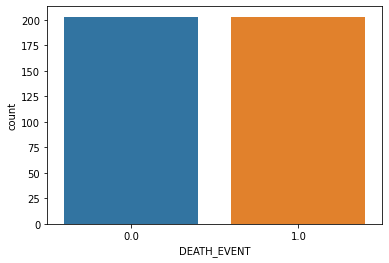

In [11]:
from imblearn.over_sampling import SMOTE
oversampling_func = SMOTE(random_state=42)
X = copy.iloc[:,:-1]
y = copy[["DEATH_EVENT"]]
print("Size of dataset before oversampling: "+str(len(X)))
X_smote, y_smote = oversampling_func.fit_resample(X, y)
smote_dataset = pd.concat((X_smote,y_smote),axis=1)
sns.countplot(x="DEATH_EVENT", data=smote_dataset)

In [12]:
smote_dataset.to_csv(r'DS1_with_outliers_balanced.csv')

In [13]:
smote_dataset

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0.636364,0.0,0.071319,0.0,0.090909,1.0,0.290823,0.157303,0.485714,1.0,0.000000,0.000000,1.0
1,0.272727,0.0,1.000000,0.0,0.363636,0.0,0.288833,0.067416,0.657143,1.0,0.000000,0.007117,1.0
2,0.454545,0.0,0.015693,0.0,0.090909,0.0,0.165960,0.089888,0.457143,1.0,1.000000,0.010676,1.0
3,0.181818,1.0,0.011227,0.0,0.090909,0.0,0.224148,0.157303,0.685714,1.0,0.000000,0.010676,1.0
4,0.454545,1.0,0.017479,1.0,0.090909,0.0,0.365984,0.247191,0.085714,0.0,0.000000,0.014235,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.191214,0.0,0.071319,0.0,0.346044,0.0,0.361392,0.167754,0.798697,1.0,0.000000,0.248656,1.0
402,0.393064,0.0,0.187083,0.0,0.138811,0.0,0.327651,0.097575,0.672264,1.0,0.000000,0.726395,1.0
403,0.663123,0.0,0.051869,0.0,0.319216,0.0,0.199377,0.144085,0.526706,0.0,0.000000,0.469910,1.0
404,0.678566,1.0,0.035355,0.0,0.237029,1.0,0.287376,0.414122,0.540813,1.0,0.535775,0.072566,1.0


In [14]:
for col in smote_dataset:
    if(col != 'DEATH_EVENT'):
        Q1=smote_dataset[col].quantile(0.25)
        Q3=smote_dataset[col].quantile(0.75)
        iqr=Q3-Q1
        lowerlimit=Q1-1.5*iqr
        upperlimit=Q3+1.5*iqr
        smote_dataset=smote_dataset[(smote_dataset[col]>lowerlimit) & (smote_dataset[col]<upperlimit)]
        #SE TEMOS O DATA SET SMOTED, PODEMOS REMOVER OS RECORDS?
        #TEMOS QUE MUDAR ISTO PARA NÃO RETIRAR TANTOS
        #VER QUANTAS VEZES É OUTLIER, METER UM THRESHOLD TIPO SER OUTLIER EM 3,4 OU 5, E EXPERIMENTAR

smote_dataset
        

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0.636364,0.0,0.071319,0.0,0.090909,1.00000,0.290823,0.157303,0.485714,1.0,0.0,0.000000,1.0
2,0.454545,0.0,0.015693,0.0,0.090909,0.00000,0.165960,0.089888,0.457143,1.0,1.0,0.010676,1.0
3,0.181818,1.0,0.011227,0.0,0.090909,0.00000,0.224148,0.157303,0.685714,1.0,0.0,0.010676,1.0
5,0.909091,1.0,0.003062,0.0,0.393939,1.00000,0.216875,0.179775,0.542857,1.0,1.0,0.014235,1.0
6,0.636364,1.0,0.028451,0.0,0.015152,0.00000,0.123530,0.078652,0.685714,1.0,0.0,0.021352,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,0.279882,1.0,0.026556,1.0,0.191505,1.00000,0.312624,0.078283,0.696957,0.0,0.0,0.397525,1.0
398,0.181818,0.0,0.063290,0.0,0.509336,0.23838,0.173255,0.056769,0.579567,0.0,0.0,0.502852,1.0
401,0.191214,0.0,0.071319,0.0,0.346044,0.00000,0.361392,0.167754,0.798697,1.0,0.0,0.248656,1.0
403,0.663123,0.0,0.051869,0.0,0.319216,0.00000,0.199377,0.144085,0.526706,0.0,0.0,0.469910,1.0


In [15]:
smote_dataset.to_csv(r'DS1_without_outliers_balanced.csv')